# Yelp Restaurant Photos Classification

Yelp held a photo classification competition on Kaggle two years ago. It asked Kagglers
to build a model that automatically tags user-uploaded photos with multiple labels, nine
labels to be exact. In this capstone project, I would be working on designing and
building a Convolutional Neural Network to try to achieve or better the highest
benchmark score. The goal of this project is to assign a set of labels to each photo
correctly. 

## Import Libaries

In [2]:
import pandas as pd
import numpy as np
from keras.layers import Dropout, Dense, GlobalAveragePooling2D
from keras.models import Sequential
from sklearn.datasets import load_files       

# user-defined functions, can be found in this directory
from extract_bottleneck_features import *
from helper_functions import * 

%matplotlib inline

Using TensorFlow backend.


## Import Datasets

**train_photo_to_biz_ids.csv.tgz** contain the mapping
from each photo to its associated business ID. In other words, this mapping allows a
business to have more than one pictures, and we're able to tell which photos belong to
which store.

**train_photos.tgz** contain the actual photos. Photo ID is in each
photo's file name. All the images are user-uploaded, meaning they are non-uniform in
sizes and color images.

**train.csv.tgz** contains each business ID with its associated correct/truth labels. There are
2000 distinct businesses.

In [2]:
# img_folder = '../'
img_folder = "C:\\Users\\I-Chun Liu\\Documents\\Local_Code\\final_project\\data"

# test_photos_to_biz = pd.read_csv(img_folder + '/test_photo_to_biz.csv.tgz', compression='gzip', sep=',')
# test_photos_to_biz.columns = ['test_photo_id', 'business_id']

train_photo_to_biz_ids = pd.read_csv(img_folder + '/train_photo_to_biz_ids.csv.tgz', compression='gzip', sep=',')
train_photo_to_biz_ids.columns = ['train_photo_id', 'business_id']

train_labels = pd.read_csv(img_folder + '/train.csv.tgz', compression='gzip', sep=',')
train_labels.columns = ['business_id', 'labels']

print("loading dataset...")
X_train, y_train = load_dataset(img_folder + '/train_photos', train_photo_to_biz_ids, train_labels, True, True)

loading dataset...


In [3]:
# show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))

Training set has 800 samples.


## Pre-process Training Data

In [4]:
# conver RGB image to 4D tensor with shape (1, 244, 244, 3)
train_tensors = paths_to_tensor(img_folder, X_train).astype('float32')/255
print("Train tenors size: {}".format(train_tensors.shape))

Train tenors size: (800, 224, 224, 3)


### Image Augmentations

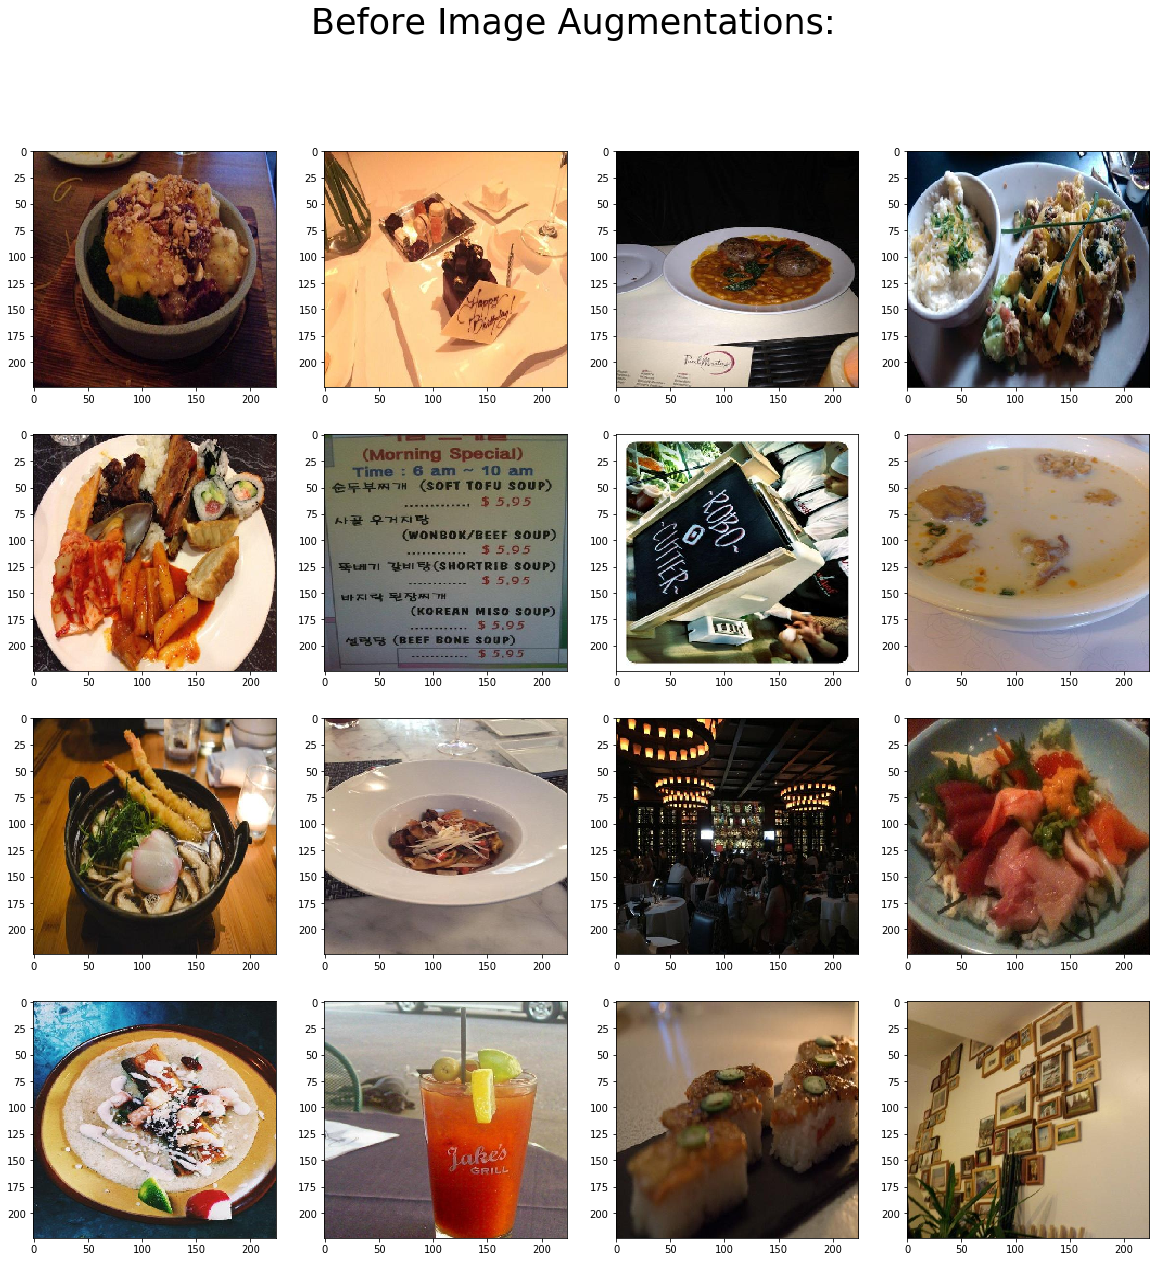

In [5]:
print_images(train_tensors, None, 'Before Image Augmentations:')

perform image augmentations for training data


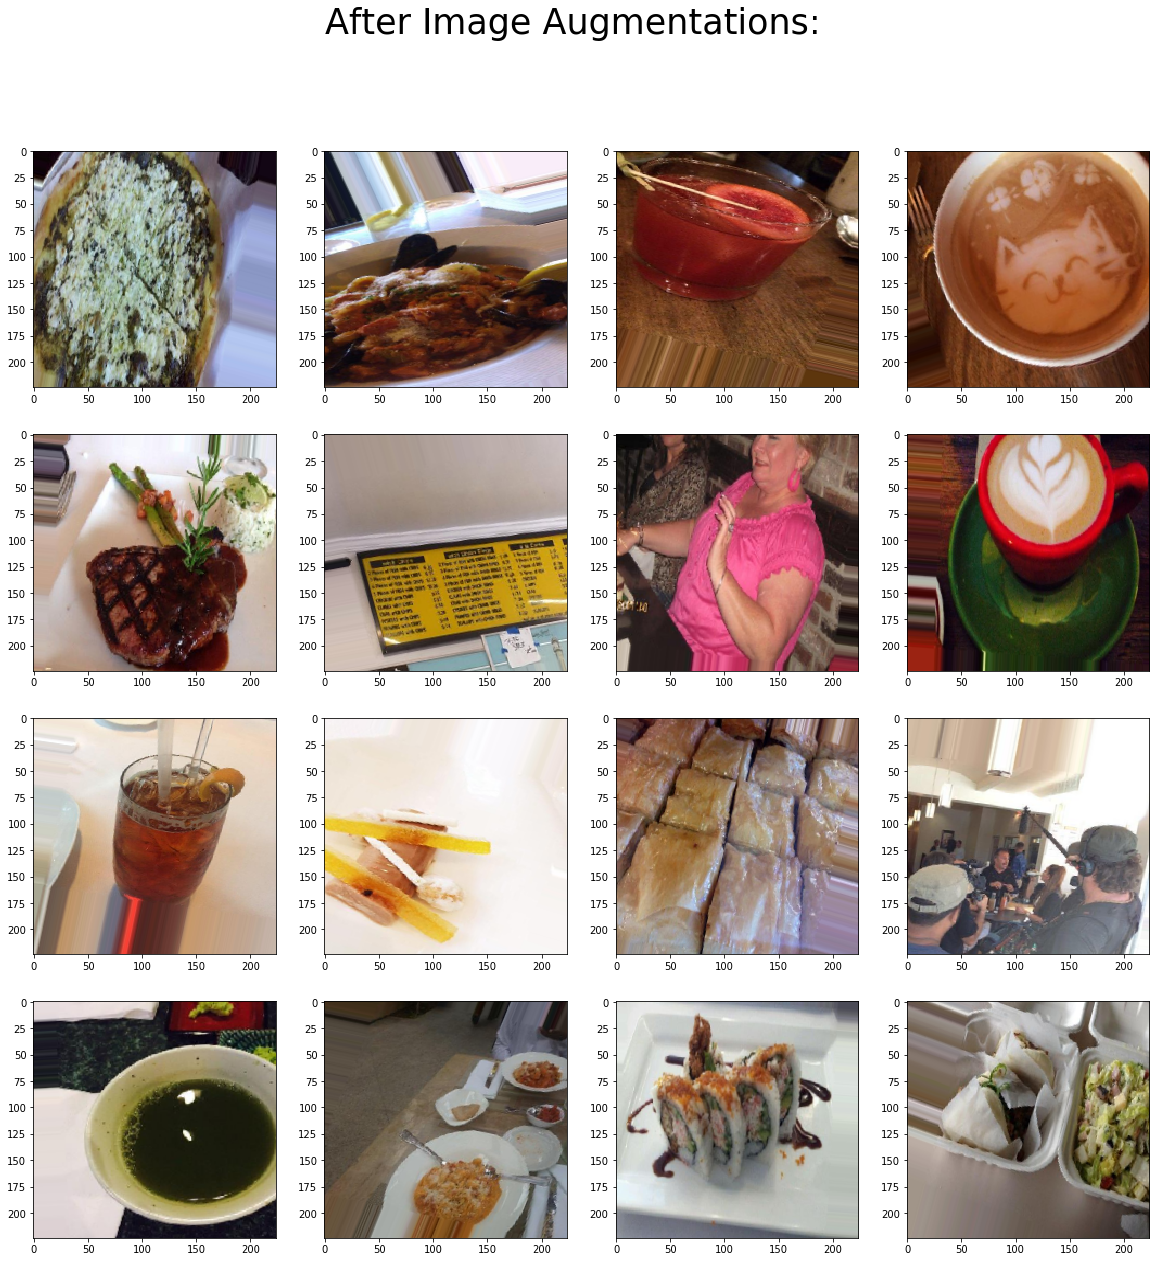

In [6]:
print("perform image augmentations for training data")
datagen_train = image.ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.05,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest')

datagen_train.fit(train_tensors)

print_images(train_tensors, datagen_train, 'After Image Augmentations:')

In [7]:
train_features = extract_Resnet50(train_tensors * 255)

print("Train features shape: {}".format(train_features.shape))

np.save('./bottleneck_features/Resnet50_train', train_features)
print("Successfully saved train bottleneck features for Resnet50_train")

processing tensor...
extracting features using Resnet50...


c:\users\i-chun liu\anaconda3\envs\cuda10\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Train features shape: (800, 7, 7, 2048)
Successfully saved train bottleneck features for Resnet50_train


## Pre-process / Feature Extraction of Validation Data

Do the same image pre-processing and bottleneck features extraction for validation set:

In [8]:
X_validation, y_validation = load_dataset(img_folder + '/train_photos', train_photo_to_biz_ids, train_labels, True, False)

print("Validation set has {} samples.".format(X_validation.shape[0]))

validation_tensors = paths_to_tensor(img_folder, X_validation).astype('float32')/255
print("Validation tenors size: {}".format(validation_tensors.shape))

# image pre-processing
datagen_validation = image.ImageDataGenerator(
                    rotation_range=20,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.05,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='nearest')
datagen_validation.fit(validation_tensors)

validation_features = extract_Resnet50(validation_tensors * 255)

print("Validation features shape: {}".format(validation_features.shape))

np.save('./bottleneck_features/Resnet50_validation', validation_features)

Validation set has 200 samples.
Validation tenors size: (200, 224, 224, 3)
processing tensor...
extracting features using Resnet50...
Validation features shape: (200, 7, 7, 2048)


# Create / Train the Model 

In [3]:
# Load bottleneck features
train_features = np.load('./bottleneck_features/Resnet50_train.npy')
y_train = np.load('./bottleneck_features/Resnet50_train_labels.npy')

validation_features = np.load('./bottleneck_features/Resnet50_validation.npy')
y_validation = np.load('./bottleneck_features/Resnet50_validation_labels.npy')

print("Train features shape: {}".format(train_features.shape))
print("Validation features shape: {}".format(validation_features.shape))

Train features shape: (800, 7, 7, 2048)
Validation features shape: (200, 7, 7, 2048)


In [4]:
epochs = 20
batch_size = 32 

model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=train_features.shape[1:]))
model.add(Dense(9, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.fit(train_features, y_train, epochs=epochs, batch_size=batch_size, validation_data=(validation_features, y_validation), verbose=2, shuffle=True)

NameError: name 'y_train' is not defined

In [5]:
model.predict(validation_features)[0]

array([0.01089719, 0.0636494 , 0.20912988, 0.10924128, 0.04622764,
       0.00716962, 0.3703864 , 0.04192509, 0.14137356], dtype=float32)

# References
1. How to use pretrained model in Keras: https://www.learnopencv.com/keras-tutorial-transfer-learning-using-pre-trained-models/


In [12]:
model.predict(validation_features)[190]

array([0.0532534 , 0.10393034, 0.1324885 , 0.10563129, 0.14653945,
       0.14427641, 0.05505163, 0.18885325, 0.06997572], dtype=float32)

In [13]:
model.evaluate(validation_features, y_validation, verbose=2)

[11.21730712890625, 0.09]